## Многомерная линейная регрессия

До этого мы рассматривали только один признак - среднее число комнат на участке. Давайте в нашу модель добавим еще один признак - процент жителей с низким социальным статусом (`LSTAT`).

In [286]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
plt.style.use("seaborn")

In [287]:
from sklearn.datasets import load_boston
boston = load_boston()

In [288]:
data = pd.DataFrame(data=boston.data, columns=boston.feature_names)
data["MEDV"] = boston.target
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


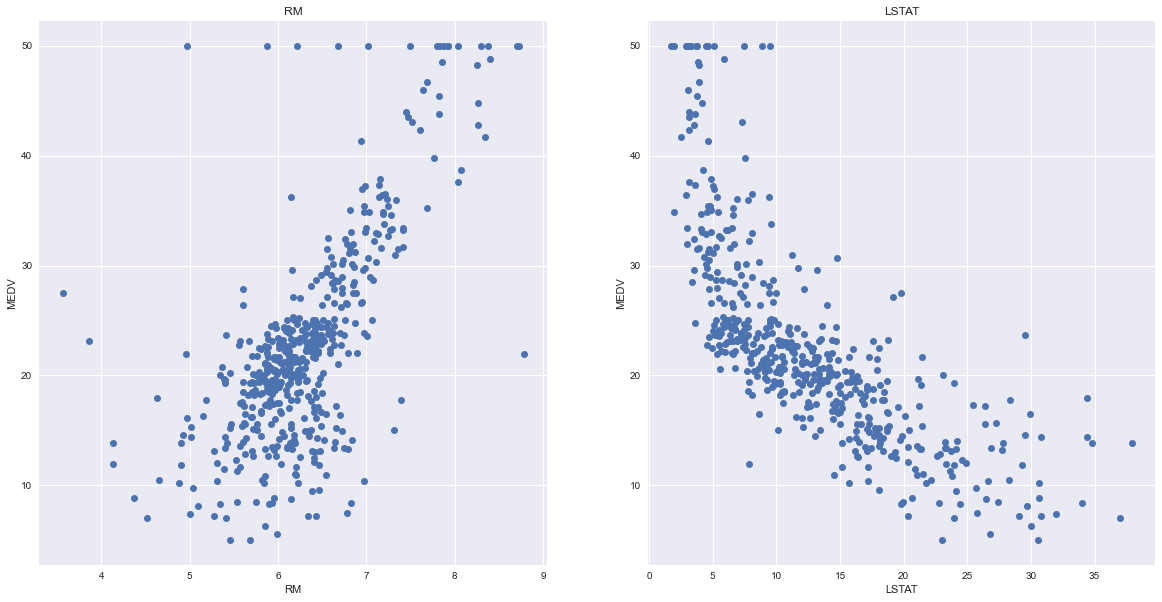

In [289]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(["RM", "LSTAT"]):
    plt.subplot(1, 2, (i+1))
    plt.plot(data[col], data["MEDV"], 'o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

In [290]:
X_filtered = data[(data["MEDV"] < 50)][["RM", "LSTAT"]]
y_filtered = data[(data["MEDV"] < 50)]["MEDV"]

In [291]:
def z_scaler(X):
    v = X.values
    l = len(v)
    s = 0
    mean_sd = sum(v) / l
    scaled = []

    if len(X.shape) == 1:
        mean = sum(X) / len(X)
        std = sqrt(sum([(x - mean) ** 2 for x in X]) / (len(X) - 1))
        X = [(x - mean) / std for x in X]
        return X

    for i in range(l):
        s += (v[i] - mean_sd)**2

    sd = np.sqrt(s / (l - 1))

    for i in range(l):
        scaled.append((v[i] - mean_sd) / sd)

    return pd.DataFrame(scaled)

In [292]:
X_scaled = z_scaler(X_filtered)
y_scaled = z_scaler(y_filtered)

In [293]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

In [294]:
class GDRegressor:
    
    def __init__(self, alpha=0.01, n_iter=100, progress=True):
        self.alpha = alpha
        self.n_iter = n_iter
        self.disable = not progress

    def fit(self, X, y):
        X = np.hstack([np.ones((len(X), 1)), X]) 
        theta = np.zeros(X.shape[1]) 
        self.theta_history = theta.copy()
        m = len(X)   
        cost = []

        for i in range(self.n_iter):
            preds = X.dot(theta)
            theta -= self.alpha * (1 / m) * (X.T.dot(preds - y))
            self.theta_history = np.vstack([self.theta_history, theta])
            cost.append(np.sum((preds - y)**2) / (2 * m))  

        self.loss_history = cost[::-1]
        self.theta = theta
        self.intercept_ = theta[0]
        self.coef_ = theta[1:]
        
        return self.coef_, self.intercept_

    def predict(self, X_test):
        return np.hstack([np.ones((len(X_test), 1)), X_test]).dot(self.theta)

In [295]:
X_train, X_test, Y_train, Y_test =\
    train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.01, n_iter=300)
%time model.fit(X_train, Y_train)

Wall time: 18 ms


(array([ 0.35402427, -0.52633641]), -0.03138950680434718)

In [296]:
def plot_loss_function(model):
    plt.xlabel("Iterations")
    plt.ylabel("Average square loss")
    plt.plot(np.arange(model.n_iter), model.loss_history);

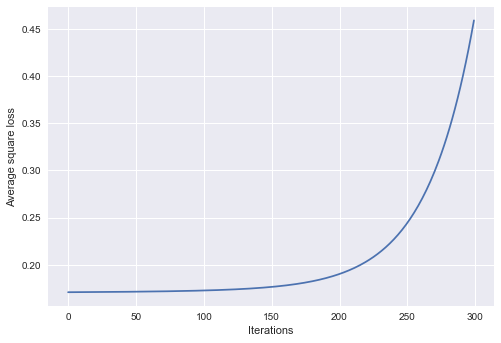

In [297]:
plot_loss_function(model)

In [298]:
def rmse(y_hat, y):
    sum1 = 0
    for i in range(len(list(y_hat))):
        sum1 += (list(y)[i] - list(y_hat)[i])**2
    result = (sum1 / len(y))**0.5
    return result


def r_squared(y_hat, y):
    y_mean = np.mean(y)
    sum1 = sum2 = 0
    for i in range(len(list(y))):
        sum1 += (list(y)[i] - list(y_hat)[i])**2
        sum2 += (list(y)[i] - y_mean)**2
    result = 1 - (sum1 / sum2)
    return result

In [299]:
Y_pred = model.predict(X_test)
rmse(Y_pred, Y_test), r_squared(Y_pred, Y_test)

(0.5900157213926532, 0.6984006249130887)

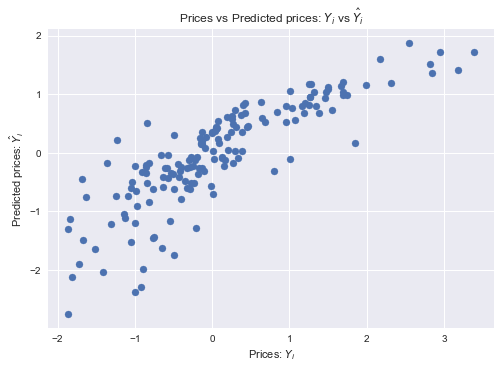

In [300]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$");

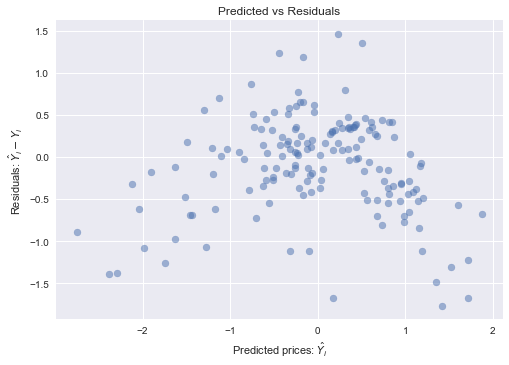

In [301]:
plt.xlabel("Predicted prices: $\hat{Y}_i$")
plt.ylabel("Residuals: $\hat{Y}_i - Y_i$")
plt.title("Predicted vs Residuals");
plt.scatter(Y_pred, (Y_pred - np.ravel(Y_test)), alpha=0.5);

Из графика хорошо видно, что есть нелинейная зависимость в остатках. Это связано с тем, что процент жителей с низким социальным статусом нелинейно зависит от средней цены на дом и среднего числа комнат:

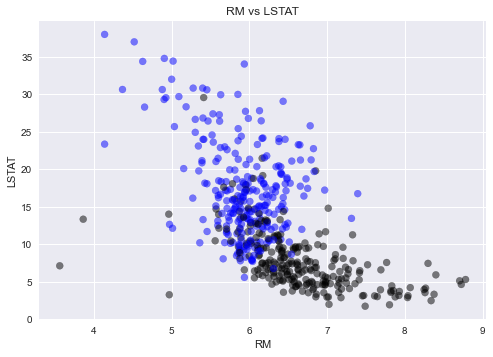

In [302]:
colors = ['k' if v > data["MEDV"].median() else 'b' for v in data["MEDV"]]
plt.scatter(data["RM"], data["LSTAT"], c=colors, alpha=0.5)
plt.xlabel("RM");
plt.ylabel("LSTAT");
plt.title("RM vs LSTAT")
plt.show()

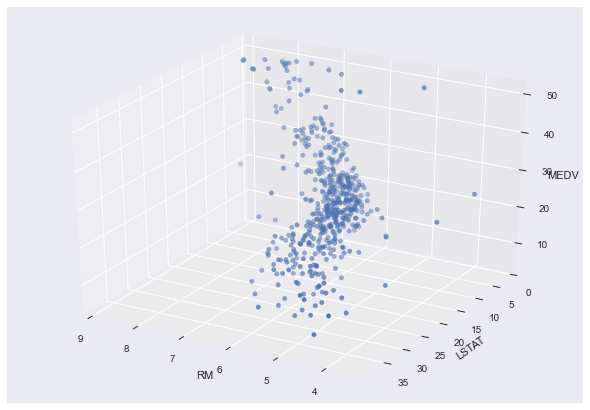

In [303]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()#figsize=(15, 10))
ax = Axes3D(fig)
ax.set_xlabel('RM')
ax.set_ylabel('LSTAT')
ax.set_zlabel('MEDV');
ax.view_init(azim=120)
ax.scatter3D(data["RM"], data["LSTAT"], data["MEDV"])
plt.show()

Эту зависимость наша модель в настоящий момент не описывает. Таким образом, мы должны добавить в нашу модель нелинейные признаки.

### Добавление полиномиальных признаков

Итак, для описания нелинейной зависимости мы будем использовать полиномиальную модель. Предположим, что полинома четвертой степени достаточно для описания зависимости. Возможно будет достаточно полинома второй или третьей степени, поэтому, чтобы «занулить» некоторые коэффициенты $\theta$, мы будем использовать L1-регуляризацию.

In [304]:
from sklearn.preprocessing import PolynomialFeatures

In [305]:
poly = PolynomialFeatures(4, include_bias=False)
X_filtered_poly = poly.fit_transform(X_filtered)

In [306]:
X_train, X_test, Y_train, Y_test =\
    train_test_split(X_filtered_poly, y_filtered, test_size = 0.33, random_state = 18)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
Y_train = y_scaler.fit_transform(Y_train.values.reshape(-1, 1))
X_test = x_scaler.transform(X_test)
Y_test = y_scaler.transform(Y_test.values.reshape(-1, 1))

In [307]:
model = SGDRegressor(
    loss='squared_loss',
    penalty='l1',
    alpha=0.01,
    learning_rate='constant',
    max_iter=1000,
    eta0=0.005
)
model.fit(X_train, Y_train.ravel())

SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.005, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [308]:
Y_pred = model.predict(X_test)

In [309]:
mean_squared_error(Y_test, Y_pred), r2_score(Y_test, Y_pred)

(0.23043272576287338, 0.8171772917852784)

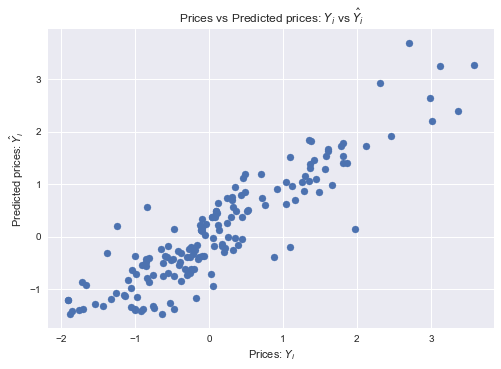

In [310]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$");

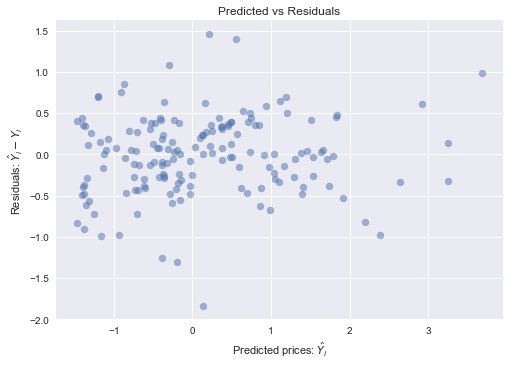

In [311]:
fig = plt.figure()
plt.scatter(Y_pred, (Y_pred-Y_test.reshape(1, -1)), alpha=0.5);
plt.xlabel("Predicted prices: $\hat{Y}_i$")
plt.ylabel("Residuals: $\hat{Y}_i - Y_i$")
plt.title("Predicted vs Residuals");
fig.savefig('lr_residuals3.png', dpi=fig.dpi)

In [312]:
model.coef_, model.intercept_

(array([ 0.01679581,  0.        ,  0.15149549, -0.10100336,  0.        ,
         0.23801815, -0.18592873,  0.        ,  0.00463806,  0.27622543,
        -0.22204522, -0.03582158,  0.        ,  0.09823455]),
 array([0.02181712]))

In [313]:
poly.get_feature_names(X_filtered.columns)

['RM',
 'LSTAT',
 'RM^2',
 'RM LSTAT',
 'LSTAT^2',
 'RM^3',
 'RM^2 LSTAT',
 'RM LSTAT^2',
 'LSTAT^3',
 'RM^4',
 'RM^3 LSTAT',
 'RM^2 LSTAT^2',
 'RM LSTAT^3',
 'LSTAT^4']

### Задания

- Постройте кривые обучения

1. Отберем наиболее подходящие признаки

In [314]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve


def learning_curves(estimator, data, features, target, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, data[features], data[target], train_sizes =
    train_sizes,
    cv = cv, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    plt.style.use('seaborn')
    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title(str(features), fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,70)

In [315]:
target = 'MEDV'
train_sizes = [1, 50, 100, 200, 400]
features = ['RM', 'LSTAT']
lstat = ['RM', 'LSTAT']

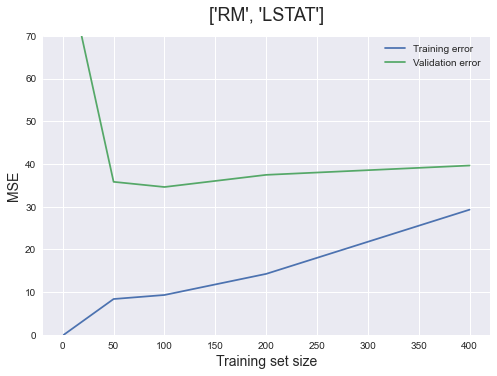

In [316]:
learning_curves(LinearRegression(), data, lstat, target, train_sizes, cv=5)

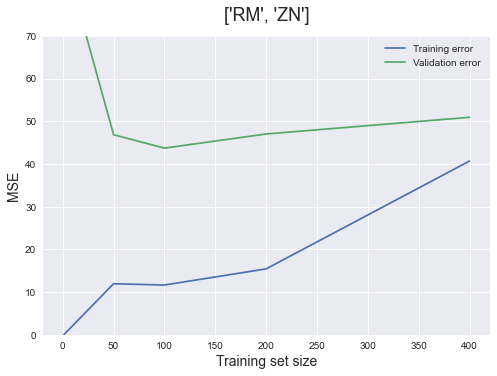

In [317]:
zn = ['RM', 'ZN']
learning_curves(LinearRegression(), data, zn, target, train_sizes, cv=5)

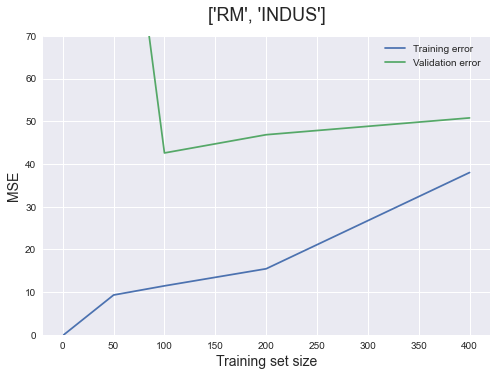

In [318]:
indus = ['RM', 'INDUS']
learning_curves(LinearRegression(), data, indus, target, train_sizes, cv=5)

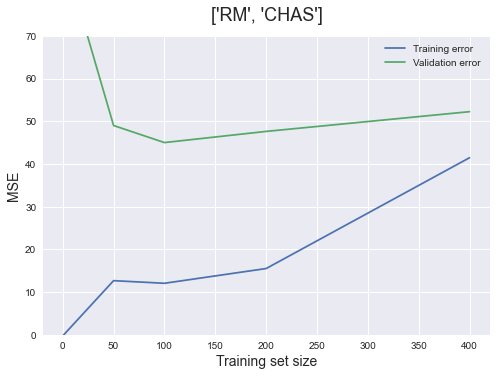

In [319]:
chas = ['RM', 'CHAS']
learning_curves(LinearRegression(), data, chas, target, train_sizes, cv=5)

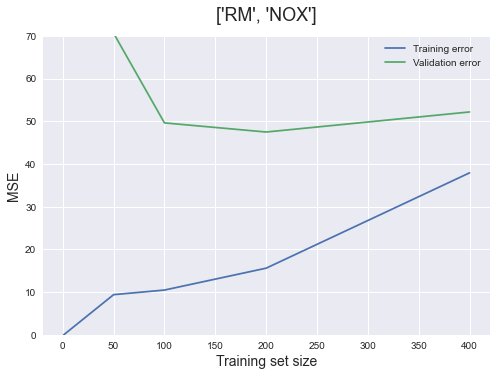

In [320]:
nox = ['RM', 'NOX']
learning_curves(LinearRegression(), data, nox, target, train_sizes, cv=5)

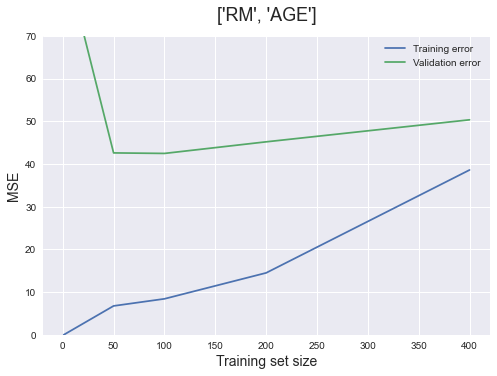

In [321]:
age = ['RM', 'AGE']
learning_curves(LinearRegression(), data, age, target, train_sizes, cv=5)

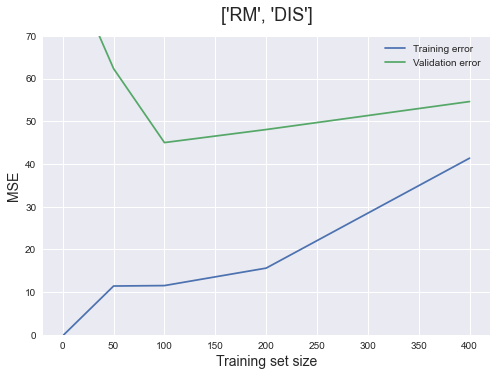

In [322]:
dis = ['RM', 'DIS']
learning_curves(LinearRegression(), data, dis, target, train_sizes, cv=5)

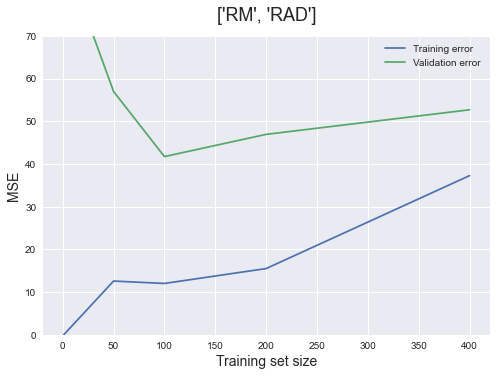

In [323]:
rad = ['RM', 'RAD']
learning_curves(LinearRegression(), data, rad, target, train_sizes, cv=5)

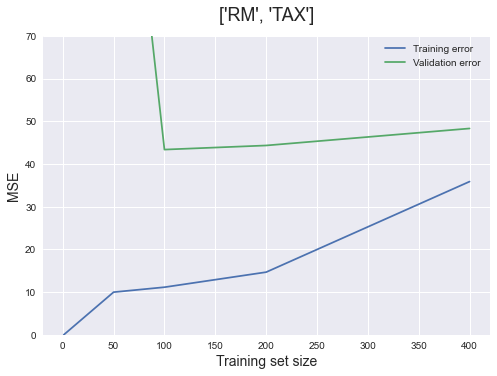

In [324]:
tax = ['RM', 'TAX']
learning_curves(LinearRegression(), data, tax, target, train_sizes, cv=5)

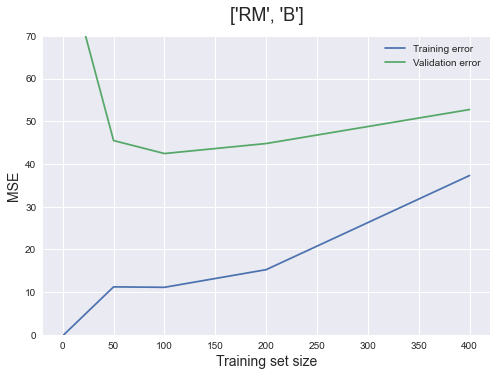

In [325]:
b = ['RM', 'B']
learning_curves(LinearRegression(), data, b, target, train_sizes, cv=5)

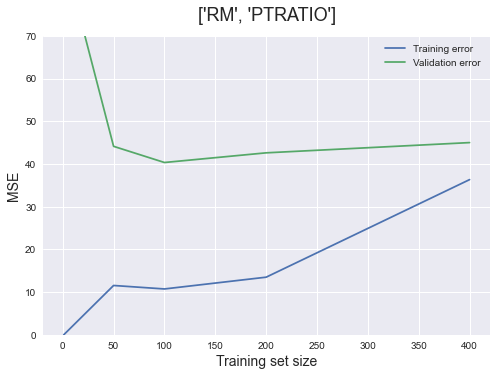

In [326]:
p = ['RM', 'PTRATIO']
learning_curves(LinearRegression(), data, p, target, train_sizes, cv=5)

In [327]:
X_filtered = data[(data["MEDV"] < 50)][["RM", "LSTAT", "PTRATIO", "ZN"]]
y_filtered = data[(data["MEDV"] < 50)][["MEDV"]]

In [328]:
X_scaled = z_scaler(X_filtered)
y_scaled = z_scaler(y_filtered)

In [329]:
poly = PolynomialFeatures(4, include_bias=False)
X_filtered_poly = poly.fit_transform(X_filtered)

In [330]:
X_train, X_test, Y_train, Y_test =\
    train_test_split(X_filtered_poly, y_filtered, test_size = 0.33, random_state = 18)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
Y_train = y_scaler.fit_transform(Y_train.values.reshape(-1, 1))
X_test = x_scaler.transform(X_test)
Y_test = y_scaler.transform(Y_test.values.reshape(-1, 1))

In [331]:
model = SGDRegressor(
    loss='squared_loss',
    penalty='l1',
    alpha=0.01,
    learning_rate='constant',
    max_iter=1000,
    eta0=0.005
)
model.fit(X_train, Y_train.ravel())

SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.005, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [332]:
Y_pred = model.predict(X_test)

In [333]:
r_squared(Y_pred, Y_test), rmse(Y_pred, Y_test)

(array([0.83408056]), array([0.45730468]))

In [334]:
def learning_curves(estimator, features, target, train_sizes, cv):
    
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, features, target, train_sizes = train_sizes,
    cv = cv, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a Linear regresion model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,170)

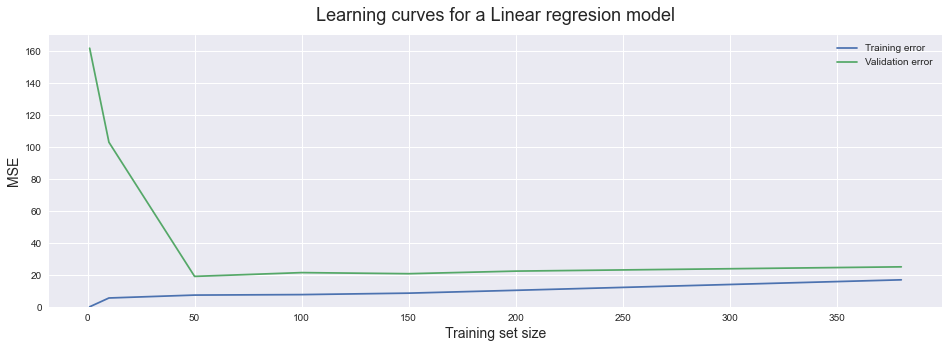

In [335]:
plt.figure(figsize = (16,5))
train_sizes = [1, 10, 50, 100, 150, 200, 380]
learning_curves(LinearRegression(), X_filtered, y_filtered, train_sizes, 5)


## Добавим L2 регуляризацию

In [338]:
X_filtered = data[(data["MEDV"] < 50)][["RM", "LSTAT"]]
y_filtered = data[(data["MEDV"] < 50)]["MEDV"]

In [339]:
poly = PolynomialFeatures(4, include_bias=False)
X_filtered_poly = poly.fit_transform(X_filtered)

In [340]:
X_train, X_test, Y_train, Y_test =\
    train_test_split(X_filtered_poly, y_filtered, test_size = 0.33, random_state = 18)

In [341]:
class Ridge:

    def __init__(self, lmbd = 0, intercept=False):
        self.lmbd = lmbd
        self.intercept = intercept

    def fit(self, X, y):

        m, n = X.shape[0], X.shape[1]
        self.theta = np.linalg.inv(X.T @ X + self.lmbd * np.eye(n)) @ X.T @ y
            
    def predict(self, X_test):
        return X_test @ self.theta

In [350]:
model = Ridge(lmbd = 0.04)
%time model.fit(X_train, Y_train)

Wall time: 1.98 ms


In [343]:
model.theta

array([ 1.15116840e+01,  7.45519350e+00, -1.69164018e+01,  7.74499507e+00,
       -1.92528716e+00,  4.08512299e+00, -2.31712458e+00,  3.72882260e-01,
        2.68342983e-02, -2.56700479e-01,  1.49783786e-01, -1.52288962e-02,
       -3.39994845e-03, -6.06070841e-05])

In [344]:
for i in range(len(poly.get_feature_names(X_filtered.columns))):
    print(poly.get_feature_names(X_filtered.columns)[i], ':', model.theta[i])

RM : 11.511683955177132
LSTAT : 7.4551935045208415
RM^2 : -16.916401754003292
RM LSTAT : 7.744995067643089
LSTAT^2 : -1.9252871604243262
RM^3 : 4.085122986023893
RM^2 LSTAT : -2.3171245830316107
RM LSTAT^2 : 0.3728822598531287
LSTAT^3 : 0.026834298311072
RM^4 : -0.25670047874652896
RM^3 LSTAT : 0.14978378627675057
RM^2 LSTAT^2 : -0.01522889624329129
RM LSTAT^3 : -0.0033999484503633636
LSTAT^4 : -6.060708406908569e-05


In [345]:
Y_pred = model.predict(X_test)

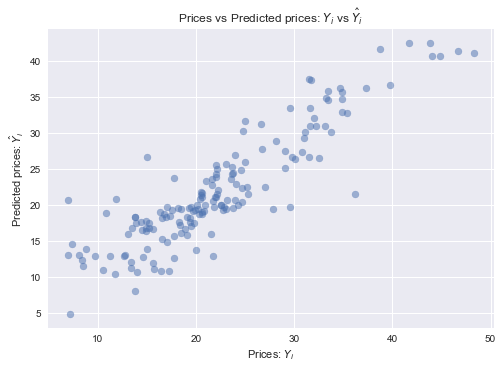

In [346]:
plt.scatter(Y_test, Y_pred, alpha=0.5)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$");

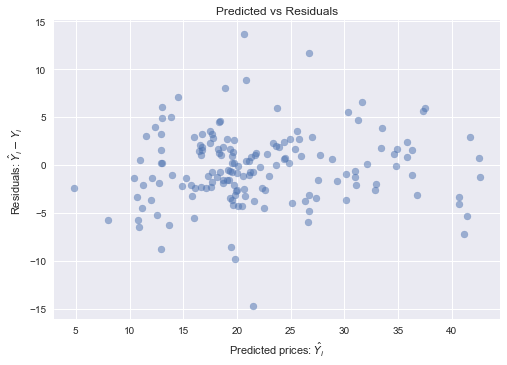

In [347]:
plt.xlabel("Predicted prices: $\hat{Y}_i$")
plt.ylabel("Residuals: $\hat{Y}_i - Y_i$")
plt.title("Predicted vs Residuals");
plt.scatter(Y_pred, (Y_pred-Y_test), alpha=0.5);

In [348]:
r_squared(Y_pred, Y_test), rmse(Y_pred, Y_test)

(0.7991619771419272, 3.7869248325246994)